(rayleigh)=
# Rayleigh-Wave Phase Velocity

In [1]:
import bayesbay as bb
from bayesbay.discretization import Voronoi1D
import numpy as np
import matplotlib.pyplot as plt
from disba import PhaseDispersion
np.random.seed(30)

In [2]:
THICKNESS = np.array([10, 10, 15, 20, 20, 20, 20, 20, 0])
VS = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
VP_VS = 1.77
VP = VS * VP_VS
RHO = 0.32 * VP + 0.77
PERIODS = np.geomspace(3, 80, 20)
RAYLEIGH_STD = 0.02

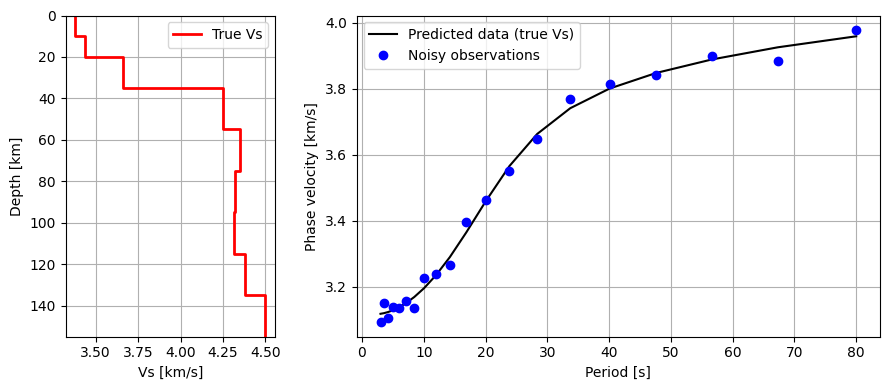

In [3]:
pd = PhaseDispersion(THICKNESS, VP, VS, RHO)
phase_vel = pd(PERIODS, mode=0, wave="rayleigh").velocity
d_obs = phase_vel + np.random.normal(0, RAYLEIGH_STD, phase_vel.size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 2.5]})
ax1 = Voronoi1D.plot_depth_profile(THICKNESS, VS, label='True Vs', ax=ax1, color='r', lw=2)
ax1.set_xlabel('Vs [km/s]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(np.cumsum(THICKNESS)[-1] + max(THICKNESS), 0)
ax1.grid()
ax1.legend()

ax2.plot(PERIODS, phase_vel, 'k', label='Predicted data (true Vs)')
ax2.plot(PERIODS, d_obs, 'bo', label='Noisy observations')
ax2.set_xlabel('Period [s]')
ax2.set_ylabel('Phase velocity [km/s]')
ax2.grid()
ax2.legend()

plt.tight_layout(w_pad=2)
plt.show()

In [4]:
def initialize_vs(param, positions=None):
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    return sorted_vals

vs = bb.parameters.UniformParameter(name="vs", 
                                    vmin=2.5, 
                                    vmax=5, 
                                    perturb_std=0.15)
vs.set_custom_initialize(initialize_vs)

In [5]:
voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=150,
    perturb_std=10,
    n_dimensions=None, 
    n_dimensions_min=4,
    n_dimensions_max=15,
    parameters=[vs], 
    birth_from='neighbour'
)
parameterization = bb.parameterization.Parameterization(voronoi)

In [6]:
def forward_sw(model):
    voronoi = model["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    pd = PhaseDispersion(thickness, vp, vs, rho)
    d_pred = pd(PERIODS, mode=0, wave="rayleigh").velocity
    return d_pred

In [7]:
target = bb.Target("rayleigh", 
                   d_obs, 
                   covariance_mat_inv=1/RAYLEIGH_STD**2)

In [8]:
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=forward_sw)

inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=20
)

inversion.run(
    sampler=None, 
    n_iterations=150_000, 
    burnin_iterations=50_000, 
    save_every=200, 
    verbose=False
)

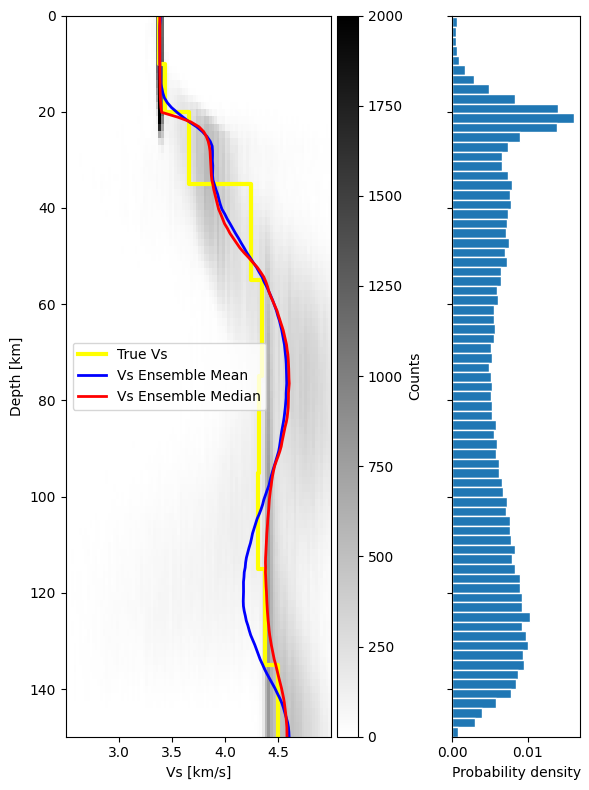

In [9]:
results = inversion.get_results(concatenate_chains=True)

sampled_voronoi_nuclei = results['voronoi.discretization']
sampled_thickness = [Voronoi1D.compute_cell_extents(n) for n in sampled_voronoi_nuclei]
sampled_vs = results['vs']
interp_depths = np.linspace(0, 160, 160)
statistics_vs = Voronoi1D.get_depth_profiles_statistics(
    sampled_thickness, sampled_vs, interp_depths
    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [2.5, 1]})
ax1, cbar = Voronoi1D.plot_depth_profiles_density(
    sampled_thickness, sampled_vs, ax=ax1, cmap='binary', vmin=0, vmax=2000
)
Voronoi1D.plot_depth_profile(THICKNESS, VS, ax=ax1, color='yellow', lw=3, label='True Vs')
ax1.plot(statistics_vs['mean'], interp_depths, 'b', lw=2, label='Vs Ensemble Mean')
ax1.plot(statistics_vs['median'], interp_depths, 'r', lw=2, label='Vs Ensemble Median')
ax1.set_xlabel("Vs [km/s]")
ax1.set_ylabel("Depth [km]")
ax1.legend()

Voronoi1D.plot_interface_hist(sampled_thickness, bins=75, ec='w', ax=ax2)
ax2.tick_params(labelleft=False)
ax2.set_ylabel('')
ax2.set_ylim(*ax1.get_ylim())
plt.tight_layout()
plt.show()



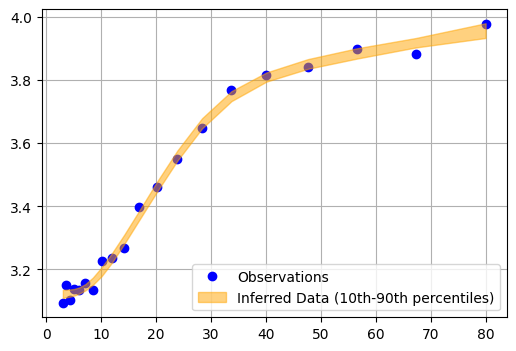

In [10]:
d_pred = np.array(results['dpred'])
percentiles = np.percentile(d_pred, (10, 90), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(PERIODS, d_obs, 'bo', label='Observations')
ax.fill_between(PERIODS, percentiles[0], percentiles[1], color='orange', alpha=0.5, label='Inferred Data (10th-90th percentiles)', zorder=100)
ax.grid()
ax.legend()
plt.show()

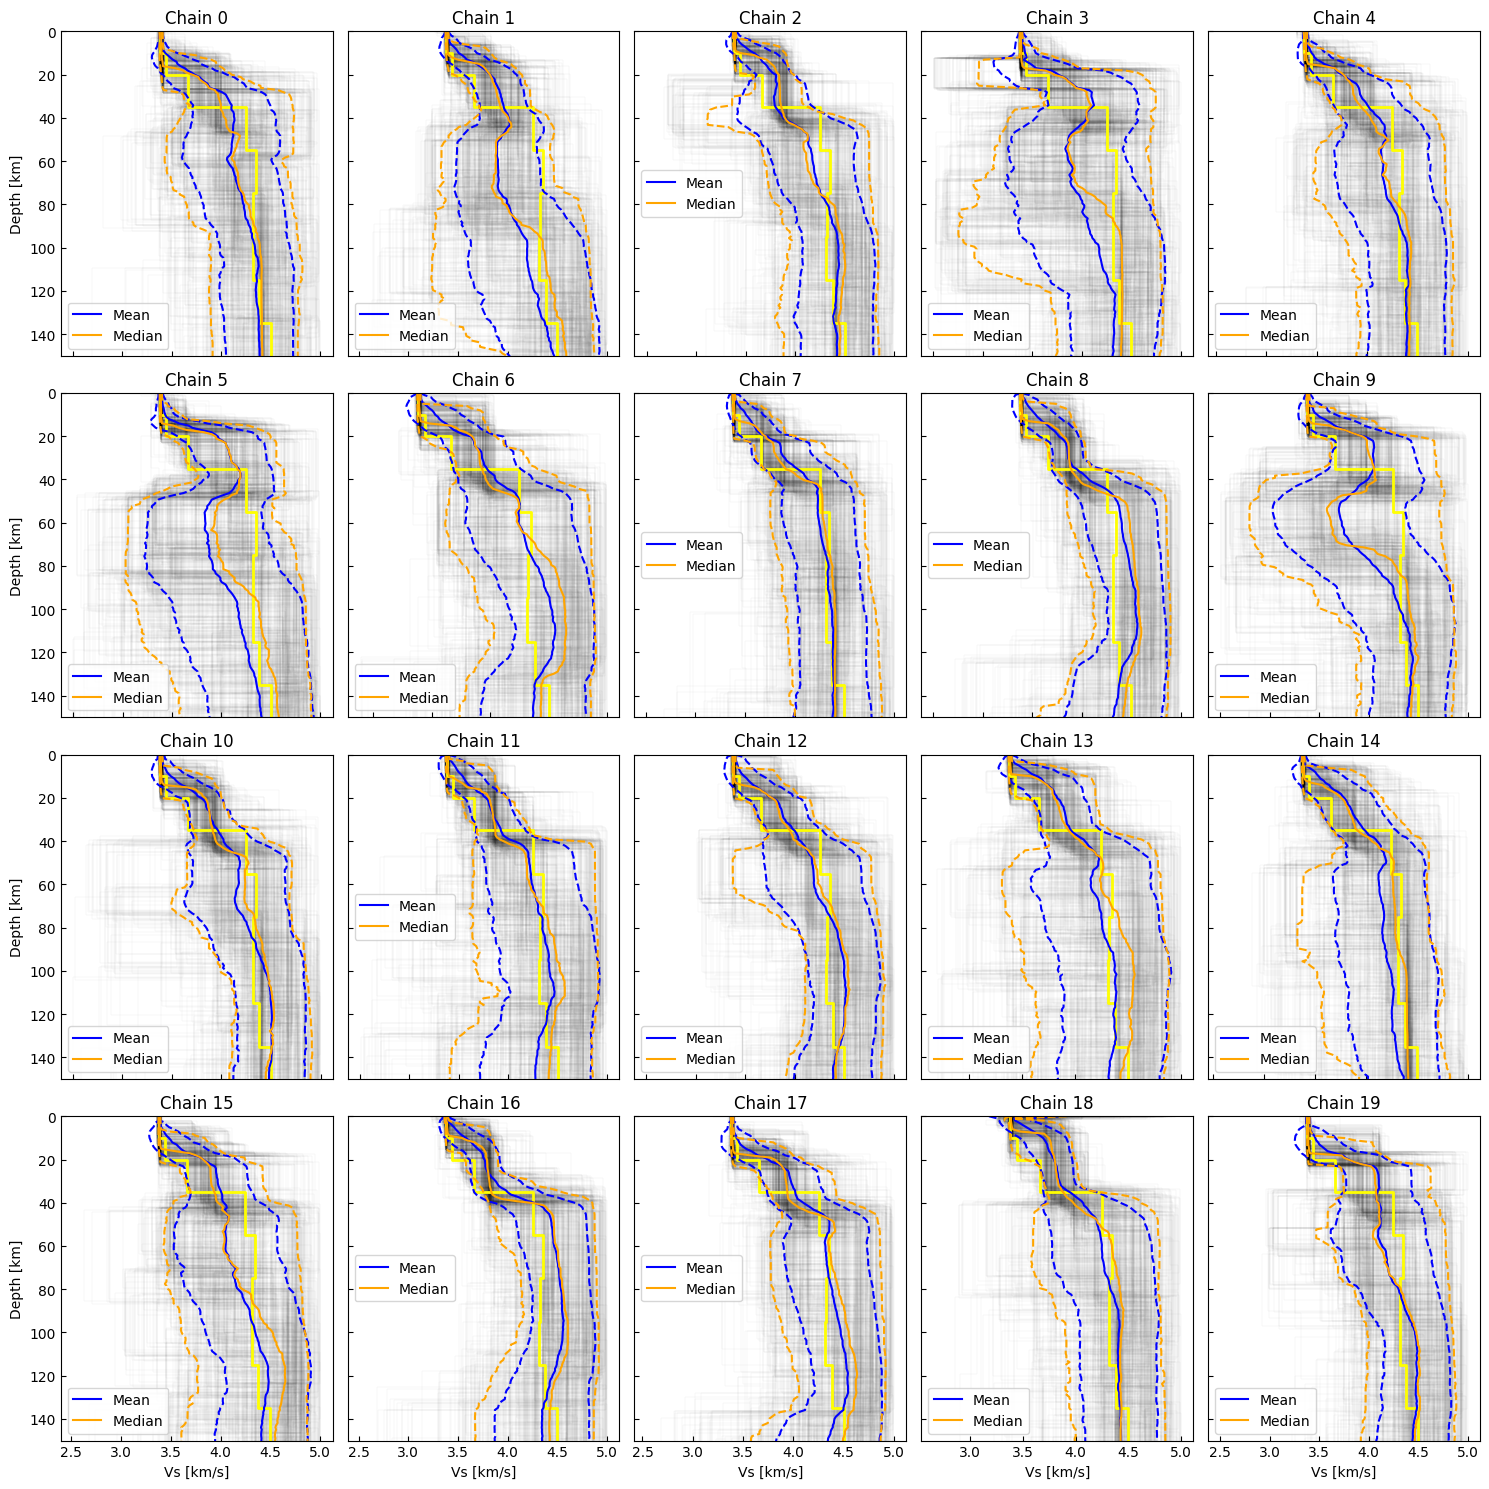

In [11]:

def get_subplot_layout(n_subplots):
    rows = int(np.sqrt(n_subplots))
    cols = int(np.ceil(n_subplots / rows))
    return rows, cols

rows, cols = get_subplot_layout(len(inversion.chains))
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for ipanel, (ax, chain) in enumerate(zip(np.ravel(axes), inversion.chains)):
    saved_models = chain.saved_models
    saved_thickness = saved_models["voronoi.discretization"]
    saved_vs = saved_models['vs']
    
    Voronoi1D.plot_depth_profiles(
    saved_thickness, saved_vs, ax=ax, linewidth=0.1, color="k", max_depth=150
)
    Voronoi1D.plot_depth_profile(THICKNESS, VS, color='yellow', lw=2, ax=ax)
    Voronoi1D.plot_depth_profiles_statistics(
        saved_thickness, saved_vs, interp_depths, ax=ax
    )
    
    ax.set_title(f'Chain {chain.id}')
    ax.tick_params(direction='in', labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if not ipanel % cols:
        ax.set_ylabel('Depth [km]')
        ax.tick_params(labelleft=True)
    if ipanel >= (rows-1) * cols:
        ax.set_xlabel('Vs [km/s]')
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()
